In [8]:
import matplotlib.pyplot as plt

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

import pathlib

data_dir = "/Users/yuu/Downloads/sjwj/mine/pokemon/PokemonData"

data_dir = pathlib.Path(data_dir)

In [9]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 6837


In [10]:
batch_size = 8
img_height = 224
img_width = 224

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6820 files belonging to 150 classes.
Using 5456 files for training.
Metal device set to: Apple M1


2023-05-23 21:30:32.817189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 21:30:32.819184: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6820 files belonging to 150 classes.
Using 1364 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

In [14]:
len(class_names)

150

2023-05-23 21:30:37.316062: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


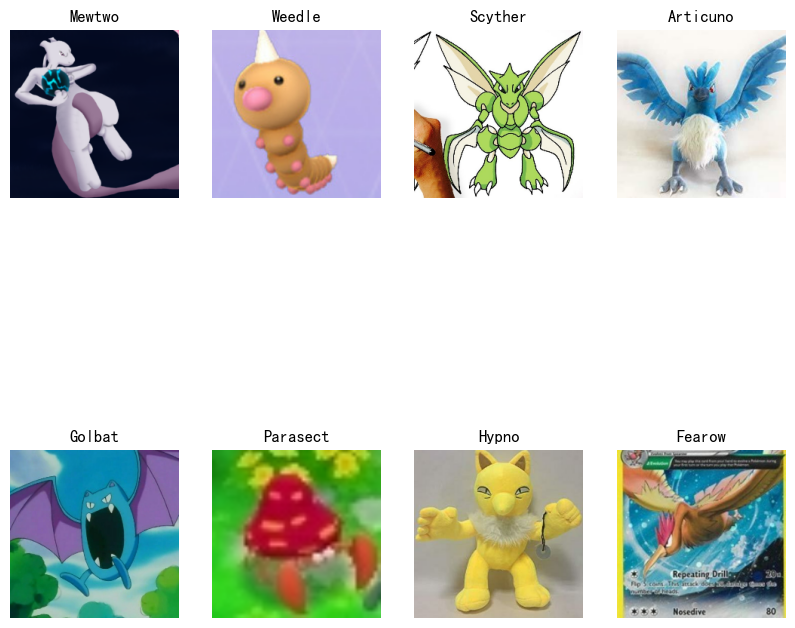

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): 
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8")) 
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 224, 224, 3)
(8,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
import  os, glob
import  random, csv
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras import layers, losses
from tensorflow import keras
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
from tensorflow.keras.layers import Rescaling

# 将像素值除以255
rescale = Rescaling(scale=1./255)

train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [20]:
model = tf.keras.applications.DenseNet121(weights='imagenet',
                                       include_top=False,
                                       input_shape=(224,224,3),
                                       pooling='avg')
model.trainable=False
x=layers.Flatten()(model.output)
x=layers.Dense(1024,activation='relu')(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(150,activation='softmax')(x)
network=Model(model.input,x)
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

In [13]:
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, 
        decay_steps=5,      
        decay_rate=0.96,    
        staircase=True)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

network.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5
)

epoch=20
history=network.fit(train_ds,
            validation_data=val_ds,
            validation_freq=1,
            epochs=epoch,
            callbacks=[early_stopping])

Epoch 1/20
682/682 [==============================] - 70s 48ms/step - loss: 4.9304 - accuracy: 0.0293 - val_loss: 4.7549 - val_accuracy: 0.0638
Epoch 2/20
682/682 [==============================] - 26s 39ms/step - loss: 4.7431 - accuracy: 0.0530 - val_loss: 4.7532 - val_accuracy: 0.0630
Epoch 3/20
682/682 [==============================] - 27s 39ms/step - loss: 4.7412 - accuracy: 0.0612 - val_loss: 4.7532 - val_accuracy: 0.0630
Epoch 4/20
682/682 [==============================] - 28s 40ms/step - loss: 4.7393 - accuracy: 0.0557 - val_loss: 4.7532 - val_accuracy: 0.0630
Epoch 5/20
682/682 [==============================] - 27s 40ms/step - loss: 4.7409 - accuracy: 0.0543 - val_loss: 4.7532 - val_accuracy: 0.0630
Epoch 6/20
682/682 [==============================] - 27s 40ms/step - loss: 4.7449 - accuracy: 0.0552 - val_loss: 4.7532 - val_accuracy: 0.0630


In [14]:
print(len(model.layers))

428


In [15]:
model.trainable=True

In [16]:
# 冻结部分层
for layer in model.layers[:200]:
    layer.trainable = False

# 编译模型
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

network.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

history=network.fit(train_ds,
            validation_data=val_ds,
            validation_freq=1,
            epochs=epoch,
            callbacks=[early_stopping])

Epoch 1/20
682/682 [==============================] - 92s 79ms/step - loss: 4.2122 - accuracy: 0.1976 - val_loss: 3.7327 - val_accuracy: 0.3512
Epoch 2/20
682/682 [==============================] - 52s 76ms/step - loss: 3.6877 - accuracy: 0.3829 - val_loss: 3.7326 - val_accuracy: 0.3504
Epoch 3/20
682/682 [==============================] - 52s 76ms/step - loss: 3.6805 - accuracy: 0.3765 - val_loss: 3.7352 - val_accuracy: 0.3468
Epoch 4/20
682/682 [==============================] - 53s 77ms/step - loss: 3.6719 - accuracy: 0.3884 - val_loss: 3.7337 - val_accuracy: 0.3453
Epoch 5/20
682/682 [==============================] - 57s 83ms/step - loss: 3.6872 - accuracy: 0.3796 - val_loss: 3.7333 - val_accuracy: 0.3497
Epoch 6/20
682/682 [==============================] - 52s 77ms/step - loss: 3.6863 - accuracy: 0.3799 - val_loss: 3.7314 - val_accuracy: 0.3504


In [17]:
model.trainable=False

for layer in model.layers[:50]:
    layer.trainable=True

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

network.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

history=network.fit(train_ds,
            validation_data=val_ds,
            validation_freq=1,
            epochs=epoch,
            callbacks=[early_stopping])

Epoch 1/20
682/682 [==============================] - 115s 104ms/step - loss: 2.2782 - accuracy: 0.5458 - val_loss: 1.2093 - val_accuracy: 0.7529
Epoch 2/20
682/682 [==============================] - 69s 101ms/step - loss: 0.7649 - accuracy: 0.8308 - val_loss: 0.6779 - val_accuracy: 0.8592
Epoch 3/20
682/682 [==============================] - 70s 102ms/step - loss: 0.4071 - accuracy: 0.9126 - val_loss: 0.5109 - val_accuracy: 0.8783
Epoch 4/20
682/682 [==============================] - 68s 100ms/step - loss: 0.2445 - accuracy: 0.9498 - val_loss: 0.4485 - val_accuracy: 0.8959
Epoch 5/20
682/682 [==============================] - 69s 101ms/step - loss: 0.1569 - accuracy: 0.9721 - val_loss: 0.3972 - val_accuracy: 0.8966
Epoch 6/20
682/682 [==============================] - 68s 100ms/step - loss: 0.0950 - accuracy: 0.9848 - val_loss: 0.3796 - val_accuracy: 0.8952
Epoch 7/20
682/682 [==============================] - 69s 101ms/step - loss: 0.0772 - accuracy: 0.9888 - val_loss: 0.3548 - val_a

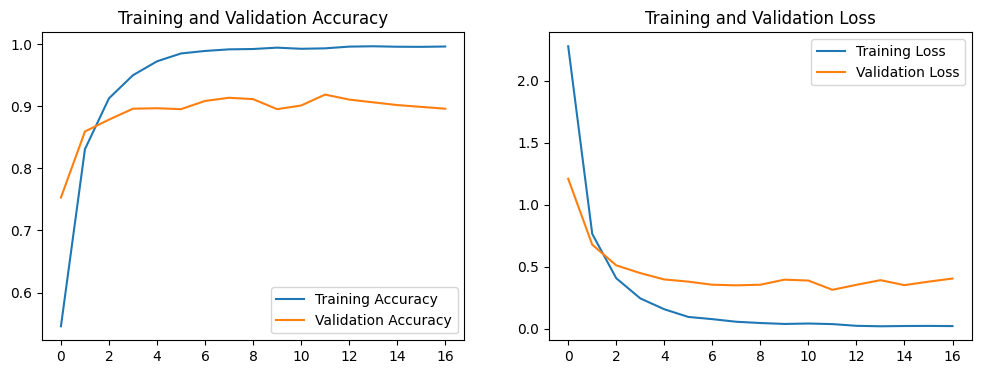

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(17)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [24]:
network.save('dense121_final.h5')

In [26]:
import os
os.chdir('/kaggle/working')
print(os.getcwd())
print(os.listdir("/kaggle/working"))
from IPython.display import FileLink
FileLink('dense121_final.h5')

/kaggle/working
['dense121_final.h5', '.virtual_documents', '__notebook_source__.ipynb']


/kaggle/working/dense121_final.h5

In [2]:
import sys
print(sys.version)
print(sys.executable)


3.9.12 (main, Apr  5 2022, 01:52:34) 
[Clang 12.0.0 ]
/Users/yuu/opt/miniconda3/bin/python
